In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 45
num_epochs = 25
learning_rate = 0.0001

In [ ]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load training data
train_path = "/content/drive/MyDrive/cnn_brainscan/train"  # Replace with your training data path
train_dataset = ImageFolder(train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Load test data
test_path = "/content/drive/MyDrive/cnn_brainscan/test"  # Replace with your test data path
test_dataset = ImageFolder(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Model
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
weights_dir = "model_weights"
os.makedirs(weights_dir, exist_ok=True)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Save model weights
    torch.save(model.state_dict(), os.path.join(weights_dir, f"model_epoch_{epoch+1}.pth"))

print("Training complete!")

Epoch 1/25, Loss: 0.6283
Epoch 2/25, Loss: 0.1138
Epoch 3/25, Loss: 0.0652
Epoch 4/25, Loss: 0.0240
Epoch 5/25, Loss: 0.0104
Epoch 6/25, Loss: 0.0154
Epoch 7/25, Loss: 0.0326
Epoch 8/25, Loss: 0.0432
Epoch 9/25, Loss: 0.0315
Epoch 10/25, Loss: 0.0269
Epoch 11/25, Loss: 0.0200
Epoch 12/25, Loss: 0.0223
Epoch 13/25, Loss: 0.0149
Epoch 14/25, Loss: 0.0102
Epoch 15/25, Loss: 0.0020
Epoch 16/25, Loss: 0.0007
Epoch 17/25, Loss: 0.0005
Epoch 18/25, Loss: 0.0009
Epoch 19/25, Loss: 0.0009
Epoch 20/25, Loss: 0.0004
Epoch 21/25, Loss: 0.0002
Epoch 22/25, Loss: 0.0004
Epoch 23/25, Loss: 0.0002
Epoch 24/25, Loss: 0.0001
Epoch 25/25, Loss: 0.0001
Training complete!


In [ ]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

In [ ]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Performance metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.99      0.99       180
 Moderate_Demented       1.00      1.00      1.00        13
      Non_Demented       0.99      1.00      0.99       640
Very_Mild_Demented       0.99      0.99      0.99       448

          accuracy                           0.99      1281
         macro avg       1.00      0.99      0.99      1281
      weighted avg       0.99      0.99      0.99      1281



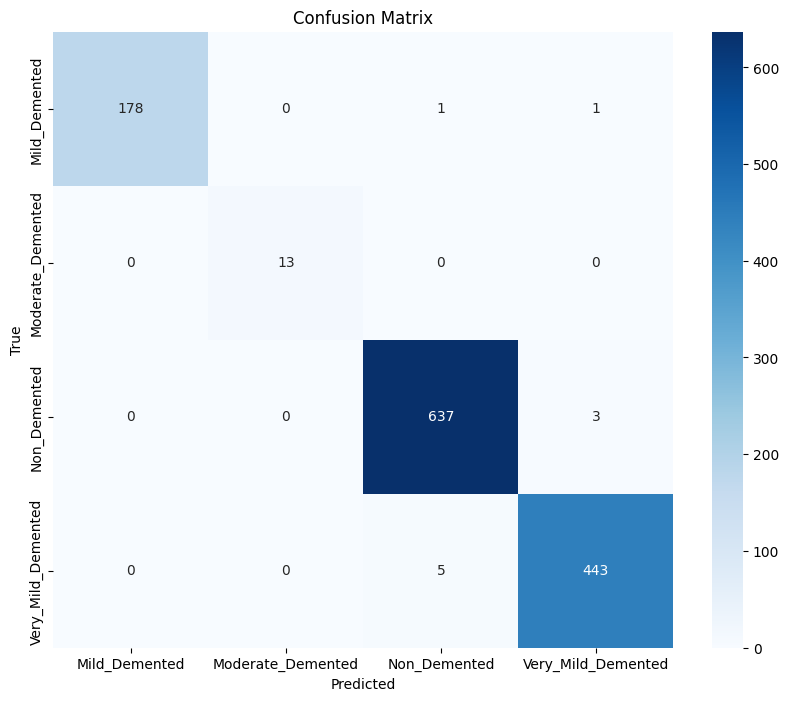

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Accuracy
accuracy = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
print(f"\nAccuracy: {accuracy:.4f}")


Accuracy: 0.9922
